## Testes adicionais


Este caderno tem como objetivo tentar melhorar os resultados obtidos no modelo de variáveis desagregadas para 2018 a 2024.

### Bibliotecas e base de dados

In [1]:
# Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import make_scorer, recall_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression  # Importar regressão logística

from skopt import BayesSearchCV
from skopt.space import Real, Integer

#Estilizar conteúdo
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    return (
        df.style.set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '100px')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', '#ffffff')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},  # Bordas cinza escuro
            ]
        ).set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        ).set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        ).format(
            precision=casas_decimais  
        )
    )

# Função para plotar as curvas ROC e PR
def plot_roc_pr_curves(y_test, y_pred_proba, model_name):
    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Curva ROC - {model_name}')
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiros Positivos')
    plt.legend(loc='lower right')
    plt.show()

    # Curva de Precisão-Revocação
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure()
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.title(f'Curva de Precisão-Revocação - {model_name}')
    plt.xlabel('Revocação')
    plt.ylabel('Precisão')
    plt.legend(loc='lower left')
    plt.show()

# Importar a base de dados

df_eventos_2018_2024_modelo2 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo2.csv",
    sep=';',
    decimal=',',
)

estilo_tabelas(df_eventos_2018_2024_modelo2.head(5))

,Status,DH_MORTOS,DH_FERIDOS,DH_ENFERMOS,DH_DESABRIGADOS,DH_DESALOJADOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DM_Uni Habita Danificadas,DM_Uni Habita Destruidas,DM_Uni Habita Valor,DM_Inst Saúde Danificadas,DM_Inst Saúde Destruidas,DM_Inst Saúde Valor,DM_Inst Ensino Danificadas,DM_Inst Ensino Destruidas,DM_Inst Ensino Valor,DM_Inst Serviços Danificadas,DM_Inst Serviços Destruidas,DM_Inst Serviços Valor,DM_Inst Comuni Danificadas,DM_Inst Comuni Destruidas,DM_Inst Comuni Valor,DM_Obras de Infra Danificadas,DM_Obras de Infra Destruidas,DM_Obras de Infra Valor,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),DensidadePop,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Sigla_UF_AC,Sigla_UF_AL,Sigla_UF_AM,Sigla_UF_AP,Sigla_UF_BA,Sigla_UF_CE,Sigla_UF_DF,Sigla_UF_ES,Sigla_UF_GO,Sigla_UF_MA,Sigla_UF_MG,Sigla_UF_MS,Sigla_UF_MT,Sigla_UF_PA,Sigla_UF_PB,Sigla_UF_PE,Sigla_UF_PI,Sigla_UF_PR,Sigla_UF_RJ,Sigla_UF_RN,Sigla_UF_RO,Sigla_UF_RR,Sigla_UF_RS,Sigla_UF_SC,Sigla_UF_SE,Sigla_UF_SP,Sigla_UF_TO,Sigla_UF_pa,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500
0,1,0,0,0,0,0,0,11650,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,132466.926,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,264933.852,309089.494,58874.189,228137.484,0.000,134.493,0.305,0.191,0.559,0.167,0.091,383.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1,0,0,0,0,0,0,2548,0,0,0.000,0.000,0,0.000,0.000,0,0.000,0,0,0.000,0,0,0.000,0.000,0.000,0.000,0.000,103709.315,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5905738.840,603420.207,0.000,0.000,0.000,10.669,0.632,0.246,0.456,0.175,0.070,57.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0,0,180,0,0,156,0,0,112,0,515149.157,0.000,0,0.000,0.000,0,0.000,0,0,0.000,1,0,161904.021,16.000,0.000,1619040.208,161904.021,0.000,0.000,1766225.681,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,0.708,0.691,0.851,0.691,0.576,356.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000

### Inclusão de features derivadas

In [2]:
# Inclusão de features derivadas
# As features com "na" que seriam somadas a outras foram tratadas como 0. Por exemplo, caso um evento tenha feridos = 5 e enfermos = na, então o valor de feridos e enfermos = 5.

df_eventos_2018_2024_modelo2['DH_FERIDOS_ENFERMOS'] = df_eventos_2018_2024_modelo2['DH_FERIDOS'].fillna(0) + df_eventos_2018_2024_modelo2['DH_ENFERMOS'].fillna(0)
df_eventos_2018_2024_modelo2['DH_DESABRIGADOS_DESALOJADOS'] = df_eventos_2018_2024_modelo2['DH_DESABRIGADOS'].fillna(0) + df_eventos_2018_2024_modelo2['DH_DESALOJADOS'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Uni_Habita_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Uni Habita Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Uni Habita Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Saude_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Inst Saúde Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Inst Saúde Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Ensino_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Inst Ensino Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Inst Ensino Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Servicos_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Inst Serviços Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Inst Serviços Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Inst_Comuni_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Inst Comuni Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Inst Comuni Destruidas'].fillna(0)
df_eventos_2018_2024_modelo2['DM_Obras_Infra_Danificadas_Destruidas'] = df_eventos_2018_2024_modelo2['DM_Obras de Infra Danificadas'].fillna(0) + df_eventos_2018_2024_modelo2['DM_Obras de Infra Destruidas'].fillna(0)

#Excluir colunas que repetidas após agregação

colunas_a_remover = ['DH_FERIDOS', 'DH_ENFERMOS', 'DH_DESABRIGADOS', 'DH_DESALOJADOS',
                     'DM_Uni Habita Danificadas', 'DM_Uni Habita Destruidas',
                     'DM_Inst Saúde Danificadas', 'DM_Inst Saúde Destruidas', 
                     'DM_Inst Ensino Danificadas', 'DM_Inst Ensino Destruidas', 
                     'DM_Inst Serviços Danificadas', 'DM_Inst Serviços Destruidas', 
                     'DM_Inst Comuni Danificadas', 'DM_Inst Comuni Destruidas', 
                     'DM_Obras de Infra Danificadas', 'DM_Obras de Infra Destruidas', ]

df_eventos_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.drop(columns=colunas_a_remover)

#Excluir linhas com dados ausentes
df_eventos_2018_2024_modelo2 = df_eventos_2018_2024_modelo2.dropna()

estilo_tabelas(df_eventos_2018_2024_modelo2.head())

,Status,DH_MORTOS,DH_DESAPARECIDOS,DH_OUTROS AFETADOS,DM_Uni Habita Valor,DM_Inst Saúde Valor,DM_Inst Ensino Valor,DM_Inst Serviços Valor,DM_Inst Comuni Valor,DM_Obras de Infra Valor,PEPL_Assis_méd e emergên(R$),PEPL_Abast de água pot(R$),PEPL_sist de esgotos sanit(R$),PEPL_Sis limp e rec lixo (R$),PEPL_Sis cont pragas (R$),PEPL_distrib energia (R$),PEPL_Telecomunicações (R$),PEPL_Tran loc/reg/l_curso (R$),PEPL_Distrib combustíveis(R$),PEPL_Segurança pública (R$),PEPL_Ensino (R$),PEPR_Agricultura (R$),PEPR_Pecuária (R$),PEPR_Indústria (R$),PEPR_Comércio (R$),PEPR_Serviços (R$),DensidadePop,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS,Sigla_UF_AC,Sigla_UF_AL,Sigla_UF_AM,Sigla_UF_AP,Sigla_UF_BA,Sigla_UF_CE,Sigla_UF_DF,Sigla_UF_ES,Sigla_UF_GO,Sigla_UF_MA,Sigla_UF_MG,Sigla_UF_MS,Sigla_UF_MT,Sigla_UF_PA,Sigla_UF_PB,Sigla_UF_PE,Sigla_UF_PI,Sigla_UF_PR,Sigla_UF_RJ,Sigla_UF_RN,Sigla_UF_RO,Sigla_UF_RR,Sigla_UF_RS,Sigla_UF_SC,Sigla_UF_SE,Sigla_UF_SP,Sigla_UF_TO,Sigla_UF_pa,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500,DH_FERIDOS_ENFERMOS,DH_DESABRIGADOS_DESALOJADOS,DM_Uni_Habita_Danificadas_Destruidas,DM_Inst_Saude_Danificadas_Destruidas,DM_Inst_Ensino_Danificadas_Destruidas,DM_Inst_Servicos_Danificadas_Destruidas,DM_Inst_Comuni_Danificadas_Destruidas,DM_Obras_Infra_Danificadas_Destruidas
0,1,0,0,11650,0.000,0.000,0.000,0.000,0.000,0.000,0.000,132466.926,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,264933.852,309089.494,58874.189,228137.484,0.000,134.493,0.305,0.191,0.559,0.167,0.091,383.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0.000,0.000,0,0,0.000
1,1,0,0,2548,0.000,0.000,0.000,0.000,0.000,0.000,0.000,103709.315,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5905738.840,603420.207,0.000,0.000,0.000,10.669,0.632,0.246,0.456,0.175,0.070,57.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0.000,0.000,0,0,0.000
4,1,0,0,13245,0.000,0.000,0.000,0.000,0.000,0.000,0.000,286229.997,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1353851.954,0.000,0.000,0.000,0.000,81.646,0.242,0.157,0.187,0.063,0.028,2231.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0.000,0.000,0,0,0.000
5,1,0,0,26689,0.000,0.000,0.000,0.000,0.000,0.000,0.000,

In [3]:
# Balanceamento da variável target

status_counts = df_eventos_2018_2024_modelo2['Status'].value_counts()
print("\nBalanceamento da variável 'Status':")
display(status_counts)


Balanceamento da variável 'Status':


Status
1    7549
0     726
Name: count, dtype: int64

### Modelos

#### Treino e Teste

In [4]:
X = df_eventos_2018_2024_modelo2.drop('Status', axis=1)

y = df_eventos_2018_2024_modelo2['Status']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1
)

# Lista para armazenar os resultados
results_summary = []

### Modelo base

Classification Report - Regressão Logística Base:
                  precision    recall  f1-score   support

Não reconhecido   0.171429  0.041379  0.066667       145
    Reconhecido   0.914198  0.980795  0.946326      1510

       accuracy                       0.898489      1655
      macro avg   0.542813  0.511087  0.506496      1655
   weighted avg   0.849121  0.898489  0.869256      1655



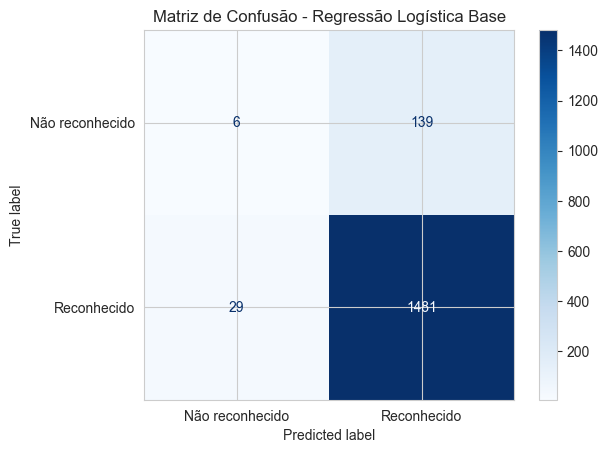

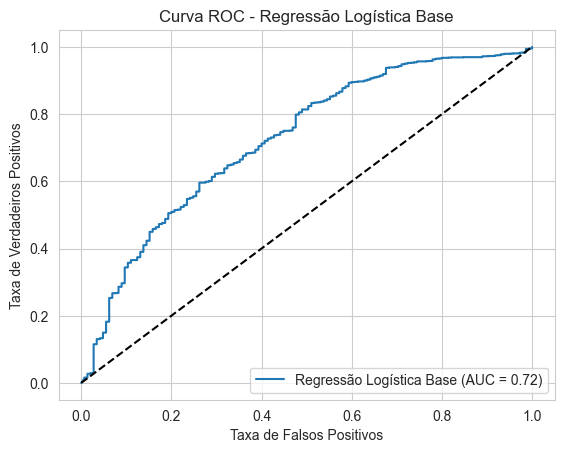

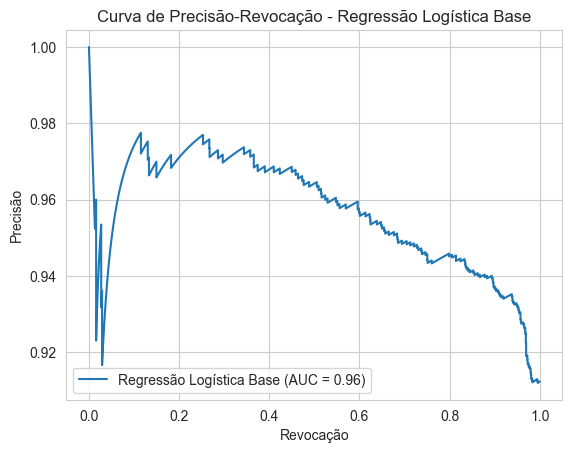

In [5]:
# Modelo base da Regressão Logística
logreg_base = LogisticRegression(
    solver='saga',  # solver que suporta L1 e L2
    random_state=1,
    max_iter=10000  # Aumentando o número de iterações por segurança
)

# Treinamento do modelo
logreg_base.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred_base = logreg_base.predict(X_test)
y_pred_proba_base = logreg_base.predict_proba(X_test)[:, 1]

# Previsões no conjunto de treino
y_train_pred_base = logreg_base.predict(X_train)

# Cálculo do recall no conjunto de treino e teste
recall_train_base = recall_score(y_train, y_train_pred_base)
recall_test_base = recall_score(y_test, y_pred_base)

# Relatório de classificação
classification_report_base = classification_report(
    y_test, y_pred_base, digits=6, target_names=['Não reconhecido', 'Reconhecido']
)
print('Classification Report - Regressão Logística Base:\n', classification_report_base)

# Plotagem da Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(
    logreg_base, X_test, y_test,
    values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido']
)
plt.title('Matriz de Confusão - Regressão Logística Base')
plt.show()

# Cálculo das métricas
metrics_base = {
    'model': 'Regressão Logística Base',
    'accuracy_train': logreg_base.score(X_train, y_train),
    'accuracy_test': logreg_base.score(X_test, y_test),
    'recall_train': recall_train_base,
    'recall_test': recall_test_base,
    'precision': metrics.precision_score(y_test, y_pred_base),
    'f1': metrics.f1_score(y_test, y_pred_base),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_base),
    'auc_pr': auc(*precision_recall_curve(y_test, y_pred_proba_base)[1::-1]),
}

# Plotagem das curvas para a Regressão Logística Base
plot_roc_pr_curves(y_test, y_pred_proba_base, 'Regressão Logística Base')


#### Ajuste de Hiperparâmetros de Thakur (2020) com BayesSearchCV, scale_pos_weight = classe minoritária / classe majoritária e score = recall_score

Melhores hiperparâmetros da Regressão Logística: OrderedDict([('logreg__C', 3.260055263941865), ('logreg__penalty', 'l1')])
Classification Report - Regressão Logística Tunada:
                  precision    recall  f1-score   support

Não reconhecido   0.191083  0.206897  0.198675       145
    Reconhecido   0.923231  0.915894  0.919548      1510

       accuracy                       0.853776      1655
      macro avg   0.557157  0.561395  0.559112      1655
   weighted avg   0.859085  0.853776  0.856390      1655



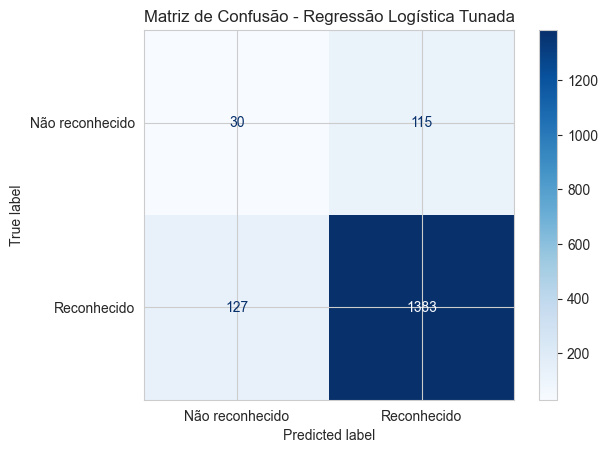

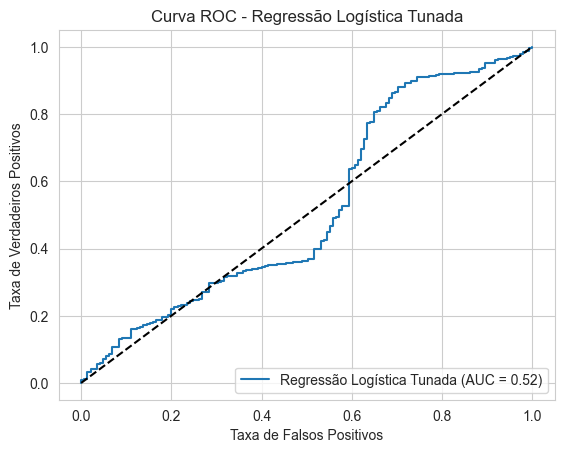

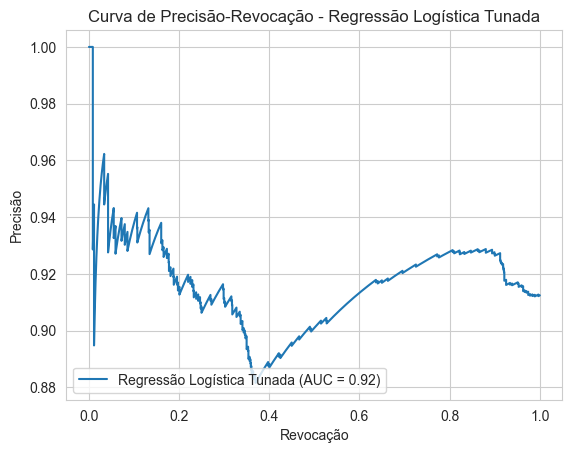

In [6]:
# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': (0.001, 100, 'log-uniform')  # Busca em escala logarítmica
}

# Usar recall como métrica de scoring
scorer = make_scorer(recall_score)

# Criar pipeline com RobustScaler e Logistic Regression
pipeline_logreg = Pipeline([
    ('scaler', RobustScaler()),  
    ('logreg', LogisticRegression(
        solver='saga',  # solver que suporta L1 e L2
        random_state=1,
        max_iter=10000  # Aumentando o número de iterações por segurança
    ))
])

# Realizar a busca bayesiana com validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

bayes_search_logreg = BayesSearchCV(
    pipeline_logreg,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=1
)

# Treinar o modelo
bayes_search_logreg.fit(X_train, y_train)

# Melhor modelo encontrado
best_logreg_model = bayes_search_logreg.best_estimator_

# Exibir os melhores hiperparâmetros
print(f"Melhores hiperparâmetros da Regressão Logística: {bayes_search_logreg.best_params_}")

# Previsões no conjunto de teste
y_pred_tuned = best_logreg_model.predict(X_test)
y_pred_proba_tuned = best_logreg_model.predict_proba(X_test)[:, 1]

# Previsões no conjunto de treino
y_train_pred_tuned = best_logreg_model.predict(X_train)

# Cálculo do recall no conjunto de treino e teste
recall_train_tuned = recall_score(y_train, y_train_pred_tuned)
recall_test_tuned = recall_score(y_test, y_pred_tuned)

# Relatório de classificação
classification_report_tuned = classification_report(
    y_test, y_pred_tuned, digits=6, target_names=['Não reconhecido', 'Reconhecido']
)
print('Classification Report - Regressão Logística Tunada:\n', classification_report_tuned)

# Plotagem da Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(
    best_logreg_model, X_test, y_test,
    values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido']
)
plt.title('Matriz de Confusão - Regressão Logística Tunada')
plt.show()

# Cálculo das métricas
metrics_tuned = {
    'model': 'Regressão Logística Tunada',
    'accuracy_train': best_logreg_model.score(X_train, y_train),
    'accuracy_test': best_logreg_model.score(X_test, y_test),
    'recall_train': recall_train_tuned,
    'recall_test': recall_test_tuned,
    'precision': metrics.precision_score(y_test, y_pred_tuned),
    'f1': metrics.f1_score(y_test, y_pred_tuned),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_tuned),
    'auc_pr': auc(*precision_recall_curve(y_test, y_pred_proba_tuned)[1::-1]),
}

# Plotagem das curvas
plot_roc_pr_curves(y_test, y_pred_proba_tuned, 'Regressão Logística Tunada')


#### Seleção de features

Ajuste de Hiperparâmetros de Thakur (2020) com BayesSearchCV, scale_pos_weight = classe minoritária / classe majoritária e score = recall_score + seleção de features por importância maior que a média

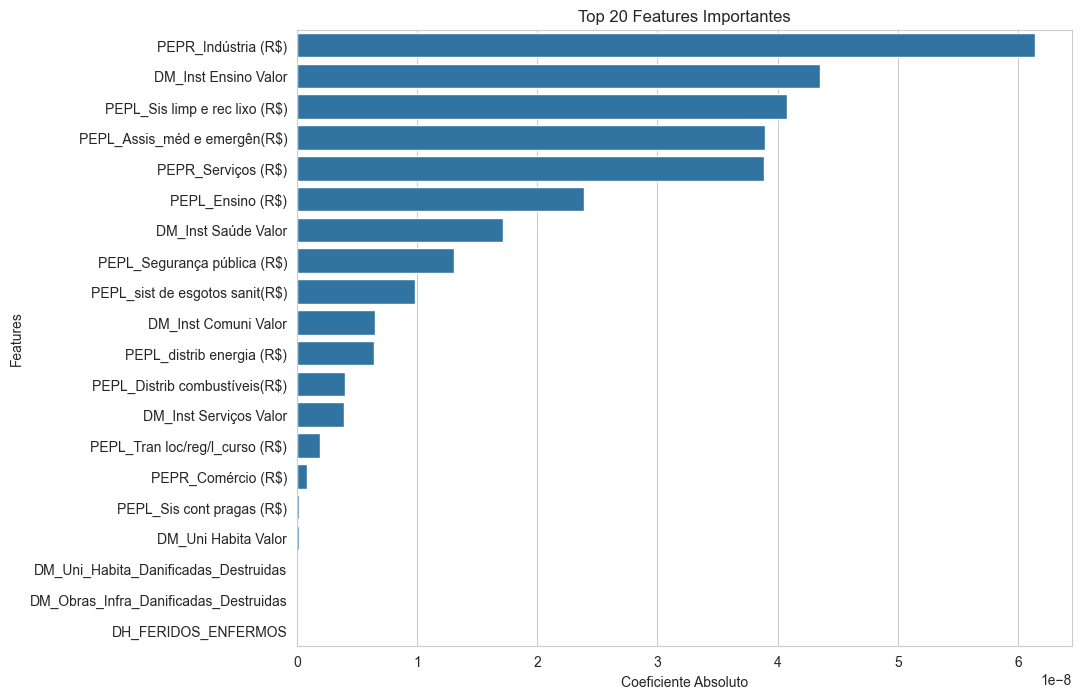

/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/brunamoura/PrevisorReconhecimento/.venv/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Classification Report - Regressão Logística com Features Selecionadas:
                  precision    recall  f1-score   support

Não reconhecido   0.142857  0.013793  0.025157       145
    Reconhecido   0.912858  0.992053  0.950809      1510

       accuracy                       0.906344      1655
      macro avg   0.527858  0.502923  0.487983      1655
   weighted avg   0.845396  0.906344  0.869710      1655



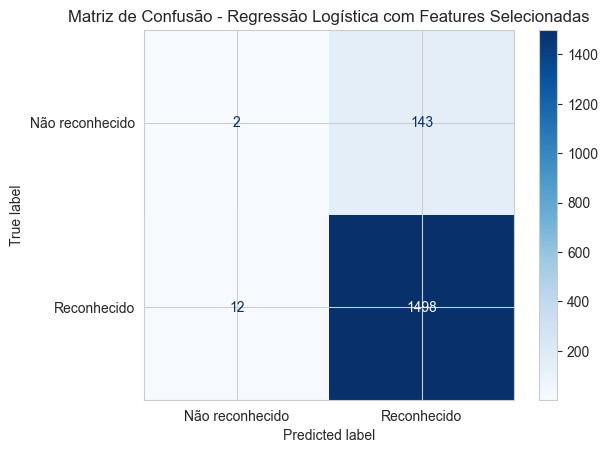

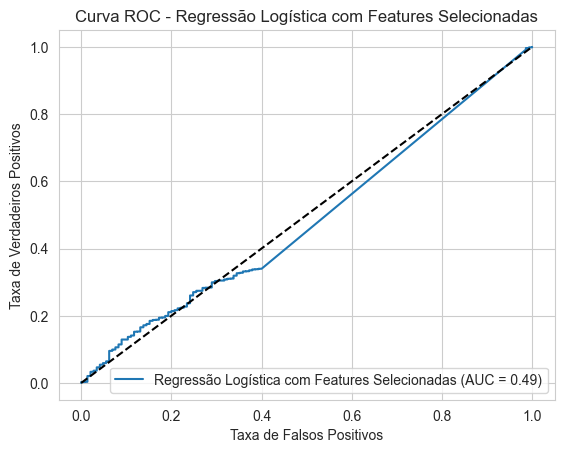

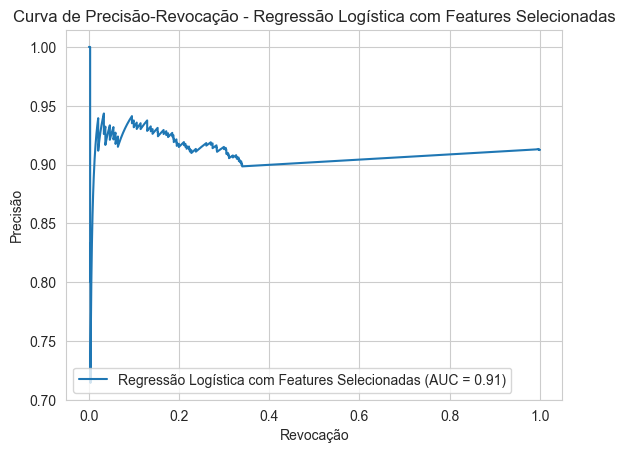

In [7]:
# Criar pipeline com RobustScaler e Logistic Regression
pipeline_logreg = Pipeline([
    ('scaler', RobustScaler()),  
    ('logreg', LogisticRegression(
        solver='saga',  # solver que suporta L1 e L2
        random_state=1,
        max_iter=10000  # Aumentando o número de iterações por segurança
    ))
])

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': (0.001, 100, 'log-uniform')  # Busca em escala logarítmica
}

# Usar recall como métrica de scoring
scorer = make_scorer(recall_score)

# Realizar a busca bayesiana com validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

bayes_search_logreg = BayesSearchCV(
    pipeline_logreg,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=1
)

# Treinar o modelo
bayes_search_logreg.fit(X_train, y_train)

# Melhor modelo encontrado
best_logreg_model = bayes_search_logreg.best_estimator_

# Acessar o estimador LogisticRegression dentro do pipeline
logreg_estimator = best_logreg_model.named_steps['logreg']

# Obter coeficientes das features
feature_importances = pd.Series(
    np.abs(logreg_estimator.coef_[0]), 
    index=X_train.columns
)
feature_importances = feature_importances.sort_values(ascending=False)

# Plotar as 20 features mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title('Top 20 Features Importantes')
plt.xlabel('Coeficiente Absoluto')
plt.ylabel('Features')
plt.show()

# Selecionar as features com coeficiente maior que a média
selector = SelectFromModel(logreg_estimator, threshold='mean', prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Atualizar o pipeline para usar apenas as features selecionadas
pipeline_logreg_selected = Pipeline([
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression(
        solver='saga',
        random_state=1,
        max_iter=10000  # Garantir convergência
    ))
])

# Realizar a busca bayesiana novamente com os dados selecionados
bayes_search_logreg_selected = BayesSearchCV(
    pipeline_logreg_selected,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=1
)

# Treinar o modelo com as features selecionadas
bayes_search_logreg_selected.fit(X_train_selected, y_train)

# Melhor modelo encontrado
best_logreg_model_selected = bayes_search_logreg_selected.best_estimator_

# Previsões no conjunto de teste
y_pred_selected = best_logreg_model_selected.predict(X_test_selected)
y_pred_proba_selected = best_logreg_model_selected.predict_proba(X_test_selected)[:, 1]

# Previsões no conjunto de treino
y_train_pred_selected = best_logreg_model_selected.predict(X_train_selected)

# Cálculo do recall no conjunto de treino e teste
recall_train_selected = recall_score(y_train, y_train_pred_selected)
recall_test_selected = recall_score(y_test, y_pred_selected)

# Relatório de classificação
classification_report_selected = classification_report(
    y_test, y_pred_selected, digits=6, target_names=['Não reconhecido', 'Reconhecido']
)
print('Classification Report - Regressão Logística com Features Selecionadas:\n', classification_report_selected)

# Plotagem da Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(
    best_logreg_model_selected, X_test_selected, y_test,
    values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido']
)
plt.title('Matriz de Confusão - Regressão Logística com Features Selecionadas')
plt.show()

# Cálculo das métricas
metrics_selected = {
    'model': 'Regressão Logística com Features Selecionadas',
    'accuracy_train': best_logreg_model_selected.score(X_train_selected, y_train),
    'accuracy_test': best_logreg_model_selected.score(X_test_selected, y_test),
    'recall_train': recall_train_selected,
    'recall_test': recall_test_selected,
    'precision': metrics.precision_score(y_test, y_pred_selected),
    'f1': metrics.f1_score(y_test, y_pred_selected),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_selected),
    'auc_pr': auc(*precision_recall_curve(y_test, y_pred_proba_selected)[1::-1]),
}

# Plotagem das curvas
plot_roc_pr_curves(y_test, y_pred_proba_selected, 'Regressão Logística com Features Selecionadas')

#### Feature Engineering

Ajuste de Hiperparâmetros de Thakur (2020) com BayesSearchCV, scale_pos_weight = classe minoritária / classe majoritária e score = recall_score + agregação das variáveis de prejuízo.

Classification Report - Regressão Logística com Feature Engineering:
                  precision    recall  f1-score   support

Não reconhecido   0.216374  0.255172  0.234177       145
    Reconhecido   0.927224  0.911258  0.919172      1510

       accuracy                       0.853776      1655
      macro avg   0.571799  0.583215  0.576674      1655
   weighted avg   0.864944  0.853776  0.859157      1655



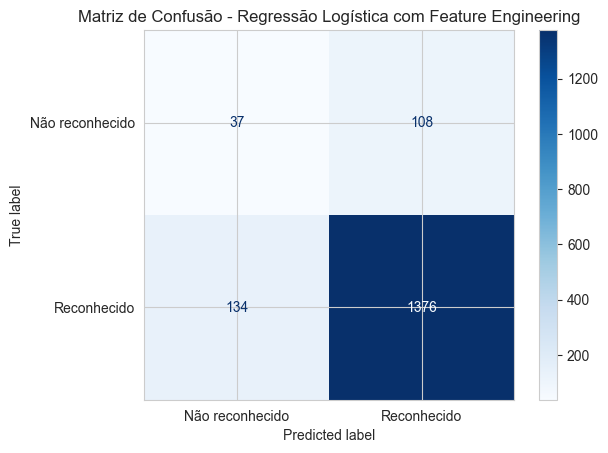

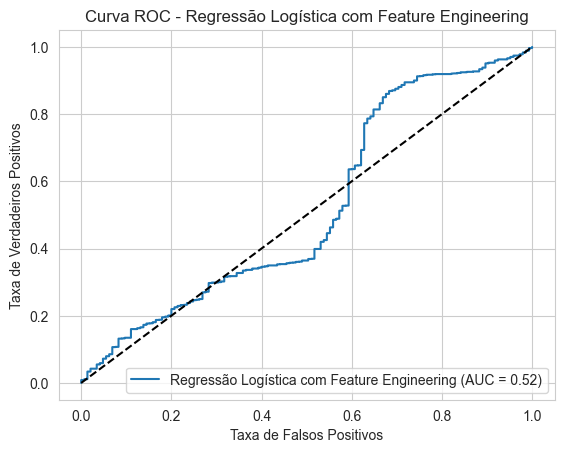

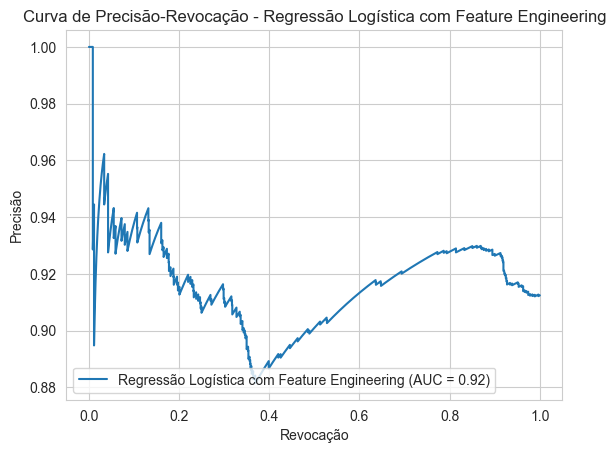

In [8]:
# Criação de novas features
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# Features agregadas
X_train_fe['PEPL_Total'] = X_train_fe.filter(like='PEPL_').sum(axis=1)
X_test_fe['PEPL_Total'] = X_test_fe.filter(like='PEPL_').sum(axis=1)

X_train_fe['PEPR_Total'] = X_train_fe.filter(like='PEPR_').sum(axis=1)
X_test_fe['PEPR_Total'] = X_test_fe.filter(like='PEPR_').sum(axis=1)

# Criar pipeline com RobustScaler e Logistic Regression
pipeline_logreg_fe = Pipeline([
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression(
        solver='saga',  # solver que suporta tanto L1 quanto L2
        random_state=1,
        max_iter=10000  # Aumentando o número de iterações por segurança
    ))
])

# Definir hiperparâmetros para a busca bayesiana
param_grid_bayes = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': (0.001, 100, 'log-uniform')  # Busca em escala logarítmica entre 0.001 e 100
}

# Usar recall como métrica de scoring
scorer = make_scorer(recall_score)

# Realizar a busca bayesiana com validação cruzada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

bayes_search_logreg_fe = BayesSearchCV(
    pipeline_logreg_fe,
    search_spaces=param_grid_bayes,
    n_iter=30,
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    random_state=1
)

# Treinar o modelo com feature engineering
bayes_search_logreg_fe.fit(X_train_fe, y_train)

# Melhor modelo encontrado
best_logreg_model_fe = bayes_search_logreg_fe.best_estimator_

# Previsões no conjunto de teste
y_pred_fe = best_logreg_model_fe.predict(X_test_fe)
y_pred_proba_fe = best_logreg_model_fe.predict_proba(X_test_fe)[:, 1]

# Previsões no conjunto de treino
y_train_pred_fe = best_logreg_model_fe.predict(X_train_fe)

# Cálculo do recall no conjunto de treino e teste
recall_train_fe = recall_score(y_train, y_train_pred_fe)
recall_test_fe = recall_score(y_test, y_pred_fe)

# Relatório de classificação
classification_report_fe = classification_report(
    y_test, y_pred_fe, digits=6, target_names=['Não reconhecido', 'Reconhecido']
)
print('Classification Report - Regressão Logística com Feature Engineering:\n', classification_report_fe)

# Plotagem da Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(
    best_logreg_model_fe, X_test_fe, y_test,
    values_format='d', cmap='Blues', display_labels=['Não reconhecido', 'Reconhecido']
)
plt.title('Matriz de Confusão - Regressão Logística com Feature Engineering')
plt.show()

# Cálculo das métricas
metrics_fe = {
    'model': 'Regressão Logística com Feature Engineering',
    'accuracy_train': best_logreg_model_fe.score(X_train_fe, y_train),
    'accuracy_test': best_logreg_model_fe.score(X_test_fe, y_test),
    'recall_train': recall_train_fe,
    'recall_test': recall_test_fe,
    'precision': metrics.precision_score(y_test, y_pred_fe),
    'f1': metrics.f1_score(y_test, y_pred_fe),
    'auc_roc': roc_auc_score(y_test, y_pred_proba_fe),
    'auc_pr': auc(*precision_recall_curve(y_test, y_pred_proba_fe)[1::-1]),
}

# Plotagem das curvas
plot_roc_pr_curves(y_test, y_pred_proba_fe, 'Regressão Logística com Feature Engineering')

### Resumo das métricas

In [9]:
# Adicionar as métricas dos diferentes modelos na lista de resultados
results_summary.append(metrics_base)
results_summary.append(metrics_tuned)
results_summary.append(metrics_selected)
results_summary.append(metrics_fe)

# Criação de um DataFrame com as métricas
resultados_modelos = pd.DataFrame(results_summary)

# Selecionar as colunas relevantes
resultados_modelos = resultados_modelos[['model', 'accuracy_train', 'accuracy_test', 'recall_train', 'recall_test', 'precision', 'f1', 'auc_roc', 'auc_pr']]

# Exibir a tabela de resultados
estilo_tabelas(resultados_modelos)

,model,accuracy_train,accuracy_test,recall_train,recall_test,precision,f1,auc_roc,auc_pr
0,Regressão Logística Base,0.901,0.898,0.982,0.981,0.914,0.946,0.723,0.957
1,Regressão Logística Tunada,0.857,0.854,0.917,0.916,0.923,0.920,0.520,0.917
2,Regressão Logística com Features Selecionadas,0.907,0.906,0.994,0.992,0.913,0.951,0.486,0.910
3,Regressão Logística com Feature Engineering,0.855,0.854,0.912,0.911,0.927,0.919,0.522,0.917
